# Damped Harmonic Oscillator with forcing
We want to solve the damped harmonic oscillator equation with a forcing term:
$$
\frac{d^2x}{dt^2} + 2\gamma \frac{dx}{dt} + \omega_0^2 x = F(t)
$$
where $x$ is the displacement, $\gamma$ is the damping coefficient, $\omega_0$ is the natural frequency, and $F(t)$ is the forcing term.
We want to rewrite this equation in the form of a first-order system. We can do this by introducing a new variable $v = \frac{dx}{dt}$, which gives us the following system of equations:
$$
\frac{dx}{dt} = v
$$
$$
\frac{dv}{dt} = -2\gamma v - \omega_0^2 x + F(t)
$$
We can now write this system in matrix form:
$$
\frac{d}{dt} \begin{pmatrix} x \\ v \end{pmatrix} = \begin{pmatrix} 0 & 1 \\ -\omega_0^2 & -2\gamma \end{pmatrix} \begin{pmatrix} x \\ v \end{pmatrix} + \begin{pmatrix} 0 \\ F(t) \end{pmatrix}
$$


In [1]:
import numpy as np

In [2]:
def ode(X, t, zeta=0.05, omega0=1.0, force=0.0):
    """
    Forced damped Harmonic Oscillator ODE
    """
    x, v = X
    dv = -2 * zeta * omega0 * v - omega0**2 * x + force
    return [v, dv]


def rk4_single_step(f, X0, t, **kwargs):
    """
    Fourth-order Runge-Kutta method for solving ODEs

    """
    assert len(t) == 2, "t must have two elements"
    dt = t[1] - t[0]
    assert dt > 0, "t must be increasing"

    k1 = f(X0, t[0], **kwargs)
    k2 = f(X0 + 0.5 * dt * np.array(k1), t[0] + 0.5 * dt, **kwargs)
    k3 = f(X0 + 0.5 * dt * np.array(k2), t[0] + 0.5 * dt, **kwargs)
    k4 = f(X0 + dt * np.array(k3), t[1], **kwargs)
    X = X0 + (dt / 6) * (
        np.array(k1) + 2 * np.array(k2) + 2 * np.array(k3) + np.array(k4)
    )

    return X

In [13]:
# Given initial conditions and a forcing over time
X0 = [1.0, 0.0]  # initial position and velocity
t = np.linspace(0, 100, 100)  # time array
# force = 5 * np.random.random(t.shape) * np.sin(0.5 * t)  # example forcing function
force = np.zeros_like(t)
X = np.zeros((len(t), len(X0)))
X[0] = X0
for i in range(1, len(t)):
    X[i] = rk4_single_step(ode, X[i - 1], [t[i - 1], t[i]], force=force[i])
    assert np.all(np.isfinite(X)), "RK4 step resulted in non-finite values"

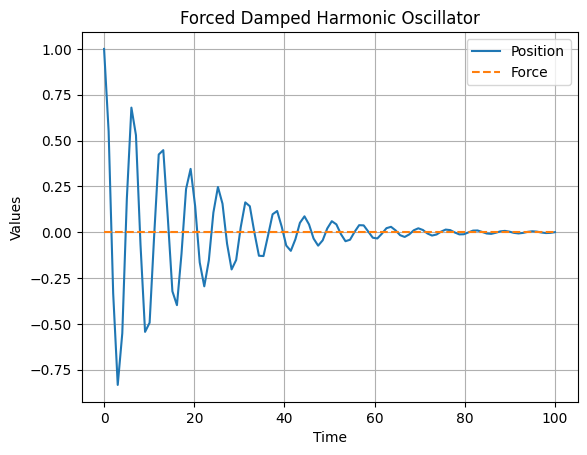

In [14]:
# Plotting the results
import matplotlib.pyplot as plt

plt.plot(t, X[:, 0], label="Position")
plt.plot(t, force, label="Force", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Forced Damped Harmonic Oscillator")
plt.legend()
plt.grid()
plt.show()

### PID Control

PID (Proportional–Integral–Derivative) control is a feedback control method that adjusts a system's input based on the error between the desired and actual output. It combines three terms:

- **Proportional (P):** reacts to the current error.
- **Integral (I):** reacts to the accumulation of past errors.
- **Derivative (D):** reacts to the predicted future error (rate of change).

The control signal is:
  
$$
u(t) = K_p e(t) + K_i \int e(t) dt + K_d \frac{d}{dt} e(t)
$$

where $e(t) = x_{\text{ref}}(t) - x(t)$ is the error.


In [15]:
class PID:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.integral = 0
        self.previous_error = 0

    def __call__(self, reference, x, dt):
        error = reference - x
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt
        self.previous_error = error
        return self.kp * error + self.ki * self.integral + self.kd * derivative

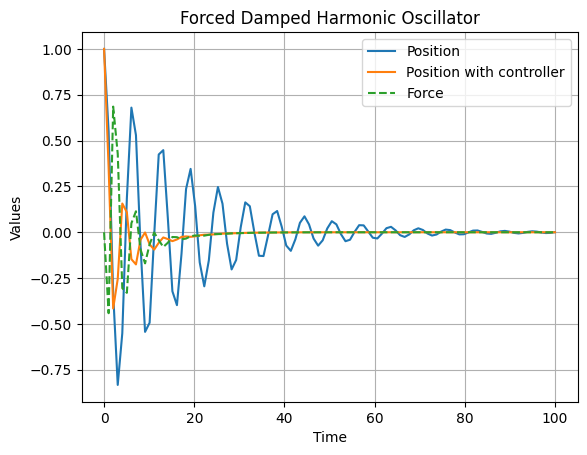

In [ ]:
controlled_X0 = [1.0, 0.0]
t = np.linspace(0, 100, 100)
controlled_X = np.zeros((len(t), len(controlled_X0)))
# controller = PID(-1.0, -0.001, 1.0)
controller = PID(-0.5, 0.05, 0.9)
references = np.zeros(t.shape)
forces = np.zeros(t.shape)
controlled_X[0] = controlled_X0
for i in range(1, len(t)):
    forces[i] = controller(
        reference=references[i], x=controlled_X[i - 1][0], dt=t[i] - t[i - 1]
    )
    controlled_X[i] = rk4_single_step(
        ode,
        controlled_X[i - 1],
        [t[i - 1], t[i]],
        force=forces[i],
    )
    assert np.all(np.isfinite(controlled_X)), "RK4 step resulted in non-finite values"

plt.plot(t, X[:, 0], label="Position")
plt.plot(t, controlled_X[:, 0], label="Position with controller")
plt.plot(t, forces, label="Force", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Controlled Damped Harmonic Oscillator")
plt.legend()
plt.grid()
plt.show()